In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

### 1. Motivation.
What is your dataset?
Why did you choose this/these particular dataset(s)?
What was your goal for the end user's experience?


It is almost general knoweldge that air pollution might be one of the main causes of respiratory diseases. An among all the broad types of respiratory diseases that exists, specifically asthma. Asthma is a chronic respiratory disease characterized by variable airflow obstruction, bronchial hyperresponsiveness, and airway inflammation. [[1]](https://pubmed.ncbi.nlm.nih.gov/32867076/) Researchers have long linked asthma with exposure to air pollution, which can make asthma symptoms worse and trigger asthma attacks. Moreover, it is estimated six million children in the United States with asthma are especially vulnerable to air pollution. [[2]](https://www.epa.gov/sciencematters/links-between-air-pollution-and-childhood-asthma#:~:text=Researchers%20have%20long%20linked%20asthma,worse%20and%20trigger%20asthma%20attacks). And not only vulnerable once they have the disease. It has been also proved that exposure to main air pollutants such as NO2, CO, and PM2.5 is linked to regional DNA methylation differences in asthma. [[3]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5756438/pdf/13148_2017_Article_433.pdf)

The aim of this study is to dig deeper into this relation between air pollution and asthma. To do so, NYC air pollution data will be used and combined with asthma hospitalizations data for children. Is there any clear correlation between air pollution and the number of asthma hospitalizations? If so, which are the air pollutants that are more correlated? How do these values vary between the different neighbourhoods? Where is more urgent to reduce the emissions of hazardous air pollutants? Is it possible to predict which is gonna be the number of asthma hospitalizations in order to prepare these hospitals that are gonna suffer more for such big workloads? 

### 2. Basic stats. Let's understand the dataset better
Write about your choices in data cleaning and preprocessing
Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

In [2]:
# Data size
df1=pd.read_csv("data/Air_Quality.csv")
df2=pd.read_csv("data/Asthma_total_data2.csv")
print('Air Quality data has a total size of %d observations and %d features'%(df1.shape))
print('Asthma Hospitalization data has a total size of %d observations and %d features'%(df2.shape))

Air Quality data has a total size of 16122 observations and 12 features
Asthma Hospitalization data has a total size of 49 observations and 1 features


#### Air quality preprocessing

In [3]:
# import air quality dataset
date_parser = lambda x: datetime.strptime(x, '%m/%d/%Y') # specify the date
df_air = pd.read_csv(
    "data/Air_Quality.csv",
    dtype={
        "Unique ID":"int64",
        "Indicator ID":"int64",
        "Geo Join ID":"int64",
        "Data Value":"float64",
    },
    parse_dates=["Start_Date"],
    date_parser=date_parser
)
df_air = df_air.drop(columns=["Message"])
print(df_air.dtypes)

Unique ID                  int64
Indicator ID               int64
Name                      object
Measure                   object
Measure Info              object
Geo Type Name             object
Geo Join ID                int64
Geo Place Name            object
Time Period               object
Start_Date        datetime64[ns]
Data Value               float64
dtype: object


In [4]:
# split date into day, month and year
df_air["Year"] = df_air.Start_Date.apply(lambda date: date.year)
df_air["Month"] = df_air.Start_Date.apply(lambda date: date.month)
df_air["Day"] = df_air.Start_Date.apply(lambda date: date.day)

# rename columns with spaces
df_air = df_air.rename(
    columns = {
        "Unique ID" : "UniqueID",
        "Indicator ID" : "IndicatorID",
        "Measure Info" : "MeasureInfo",
        "Geo Type Name" : "GeoTypeName",
        "Geo Join ID" : "GeoJoinID",
        "Geo Place Name" : "GeoPlaceName",
        "Time Period" : "TimePeriod",
        "Start_Date" : "StartDate",
        "Data Value" : "Value",
    }
)

df_air.head()

,UniqueID,IndicatorID,Name,Measure,MeasureInfo,GeoTypeName,GeoJoinID,GeoPlaceName,TimePeriod,StartDate,Value,Year,Month,Day
0,130355,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,101,Kingsbridge - Riverdale,2005-2007,2005-01-01,117.7,2005,1,1
1,130356,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,102,Northeast Bronx,2005-2007,2005-01-01,77.3,2005,1,1
2,130357,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,103,Fordham - Bronx Pk,2005-2007,2005-01-01,67.3,2005,1,1
3,130358,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,104,Pelham - Throgs Neck,2005-2007,2005-01-01,73.6,2005,1,1
4,130359,639,PM2.5-Attributable Deaths,Estimated Annual Rate - Adults 30 Yrs and Older,"per 100,000 adults",UHF42,105,Crotona -Tremont,2005-2007,2005-01-01,65.8,2005,1,1


#### Asthma dataset preprocessing

In [5]:
# Import asthma dataset
date_parser = lambda date : datetime.strptime(date, "%Y")
df = pd.read_csv(
    "data/Asthma Hospitalizations.csv",
    dtype={
        "Data":"float64"
    },
    parse_dates=["TimeFrame"],
    date_parser=date_parser
)
df["Year"] = df.TimeFrame.apply(lambda date: date.year)
print(df.dtypes)

Location              object
Age Group             object
TimeFrame     datetime64[ns]
DataFormat            object
Data                 float64
Fips                  object
Year                   int64
dtype: object


In [6]:
# there is a problem with 0-4 years being in lower caps
df["Age Group"].unique()

array(['0 to 4 years', '5 to 17 Years', '0 to 17 Years'], dtype=object)

In [7]:
# we fix that
df["Age Group"] = df["Age Group"].str.replace("y","Y")

In [8]:
# divide according to datatype and drop dataformat
df_num = df[df.DataFormat == "Number"]
df_rate = df[df.DataFormat == "Rate"]
df_num = df_num.rename(columns={"Data":"Numbers"})
df_num = df_num.drop(columns="DataFormat")
df_rate = df_rate.rename(columns={"Data":"Rate"})
df_rate = df_rate.drop(columns="DataFormat")

In [9]:
# df num has a age group that is just the sum of the other two
print(df_num["Age Group"].unique())
print(df_rate["Age Group"].unique())
# we see that 0-17 is just the sum of the other age groups, we remove that
df_num = df_num[df_num["Age Group"] != "0 to 17 Years"]
df_num["Age Group"].unique()

['0 to 4 Years' '5 to 17 Years' '0 to 17 Years']
['0 to 4 Years' '5 to 17 Years']


array(['0 to 4 Years', '5 to 17 Years'], dtype=object)

In [10]:
# for some reason, there is a single datapoint less in rate than in numbers. We ignore this one datapoint
df_merged = pd.merge(df_num, df_rate, on = ["Location", "Age Group", "TimeFrame", "Fips", "Year"], how = "outer")
print(df_merged.shape)
df_merged[df_merged.Rate.isna()]

(1344, 7)


,Location,Age Group,TimeFrame,Numbers,Fips,Year,Rate
64,Bronx,0 to 4 Years,2006-01-01,1766.0,36005,2006,NaN


In [11]:
# merge datasets and rename
df_merged = pd.merge(df_num, df_rate, on = ["Location", "Age Group", "TimeFrame", "Fips", "Year"], how = "inner")
df_hosp = df_merged

In [12]:
# split timeframe into day month and year
df_hosp["Month"] = df_hosp.TimeFrame.apply(lambda date : date.month)
df_hosp["Day"] = df_hosp.TimeFrame.apply(lambda date : date.day)

# rename columns with spaces
df_hosp=df_hosp.rename(
    columns = {"Age Group" : "AgeGroup"})

In [13]:
# handmade column names to get around multi-indexing
cols = ["Location"]
for year in range(2005, 2017):
    for cat in ("0-4y","5-17y","0-17y"):
        col = f"{year}_{cat}"
        cols.append(col)
print(cols)

['Location', '2005_0-4y', '2005_5-17y', '2005_0-17y', '2006_0-4y', '2006_5-17y', '2006_0-17y', '2007_0-4y', '2007_5-17y', '2007_0-17y', '2008_0-4y', '2008_5-17y', '2008_0-17y', '2009_0-4y', '2009_5-17y', '2009_0-17y', '2010_0-4y', '2010_5-17y', '2010_0-17y', '2011_0-4y', '2011_5-17y', '2011_0-17y', '2012_0-4y', '2012_5-17y', '2012_0-17y', '2013_0-4y', '2013_5-17y', '2013_0-17y', '2014_0-4y', '2014_5-17y', '2014_0-17y', '2015_0-4y', '2015_5-17y', '2015_0-17y', '2016_0-4y', '2016_5-17y', '2016_0-17y']


In [14]:
# import dataset
dtypes = {col:("str" if i==0 else "int") for i,col in enumerate(cols)}
df_hosp2 = pd.read_csv("data/Asthma_total_data2.csv", sep=";", names=cols).iloc[2:,:]
df_hosp2 = df_hosp2.astype(dtypes)
df_hosp2.head()

,Location,2005_0-4y,2005_5-17y,2005_0-17y,2006_0-4y,2006_5-17y,2006_0-17y,2007_0-4y,2007_5-17y,2007_0-17y,...,2013_0-17y,2014_0-4y,2014_5-17y,2014_0-17y,2015_0-4y,2015_5-17y,2015_0-17y,2016_0-4y,2016_5-17y,2016_0-17y
0.0,New York City,5027,4656,9683,5164,4525,9689,4665,4194,8859,...,7738,3922,4106,8028,3514,3547,7061,3380,3373,6753
1.0,Bronx,1791,1594,3385,1766,1542,3308,1691,1476,3167,...,3166,1569,1691,3260,1407,1489,2896,1317,1340,2657
2.0,Brooklyn,1481,1414,2895,158,1424,3004,1309,1200,2509,...,2233,1147,1155,2302,1023,994,2017,977,990,1967
3.0,Manhattan,597,698,1295,654,605,1259,526,598,1124,...,901,460,482,942,400,421,821,416,440,856
4.0,Queens,1026,831,1857,1048,823,1871,1033,814,1847,...,1239,654,663,1317,602,540,1142,559,506,1650


In [15]:
# use regex to get the UHF code from location
def get_uhf_hosp2(location):
    re_s = re.search("\(.*?\)", location)
    if re_s: return location[re_s.span()[0]+1:-1]
    else: return 0

In [16]:
# melt dataset such that each row is a sample (like the other datasets)

df_hosp2_melted = df_hosp2.melt(id_vars="Location", value_vars=list(df_hosp2.columns[1:]), var_name="Year and age", value_name="n")
df_hosp2_melted["Year"] = df_hosp2_melted["Year and age"].str[0:4].astype("int")
df_hosp2_melted["AgeGroup"] = df_hosp2_melted["Year and age"].str[5:].astype("str")
df_hosp2_melted["Uhf"] = df_hosp2_melted.Location.apply(get_uhf_hosp2)
df_hosp2_melted["Uhf"] = df_hosp2_melted["Uhf"].astype("int")
print(df_hosp2_melted.dtypes)

df_hosp2_melted_mean = df_hosp2_melted[["Uhf","n"]].groupby("Uhf", as_index=0).mean()
df_hosp2_melted = df_hosp2_melted[df_hosp2_melted.Uhf != 0]
df_hosp2_melted.head()

Location        object
Year and age    object
n                int64
Year             int64
AgeGroup        object
Uhf              int64
dtype: object


,Location,Year and age,n,Year,AgeGroup,Uhf
6,Bayside - Little Neck(404),2005_0-4y,10,2005,0-4y,404
7,Bedford Stuyvesant - Crown Heights(203),2005_0-4y,379,2005,0-4y,203
8,Bensonhurst - Bay Ridge(209),2005_0-4y,20,2005,0-4y,209
9,Borough Park(206),2005_0-4y,42,2005,0-4y,206
10,Canarsie - Flatlands(208),2005_0-4y,106,2005,0-4y,208


In [40]:
var=['Sulfur Dioxide (SO2)','Ozone (O3)','Nitrogen Dioxide (NO2)','Fine Particulate Matter (PM2.5)']
age_groups=['0-4y','5-17y']
districts=np.unique(df_hosp2_melted.Uhf)

machine_df=[]
for district_num in districts:
    district_data=df_air[df_air.GeoJoinID==district_num]
    district_data=district_data[district_data.GeoTypeName=='UHF42']
    district_data=district_data.reset_index()
    asthma_data=df_hosp2_melted[df_hosp2_melted.Uhf==district_num]
    
    for year in range(2009,2017):
        for age_group in age_groups:
            SO2=float(district_data[district_data.Name==var[0]][district_data[district_data.Name==var[0]].
                                              TimePeriod=='Winter '+str(year-1)+'-'+str(year)[-2:]].Value)
            O3=float(district_data[district_data.Name==var[1]][district_data[district_data.Name==var[1]].
                                              TimePeriod=='Summer '+str(year)].Value)
            NO2=float(district_data[district_data.Name==var[2]][district_data[district_data.Name==var[2]].
                                              TimePeriod=='Annual Average '+str(year)].Value)
            PM2_5=float(district_data[district_data.Name==var[3]][district_data[district_data.Name==var[3]].
                                              TimePeriod=='Annual Average '+str(year)].Value)
            asthma_value=int(asthma_data[asthma_data.Year==year][asthma_data[asthma_data.Year==year].
                                                             AgeGroup==age_group].n)
            row_el=[year,district_num,age_group,NO2,PM2_5,O3,SO2,asthma_value]
            machine_df.append(row_el)
            
machine_df=pd.DataFrame(machine_df,columns=['year','district','age_group','NO2','PM2_5','O3','SO2','asthma_hosp'])
sorted_df=machine_df.sort_values(by=['year','district'])

# add nyc areas to the df
nyc_ares=['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
sorted_df['Boroughs']=[nyc_ares[int(str(el)[0])-1] for el in sorted_df.district]
sorted_df.head()

"""
SHOULD I DO THAT? THEN ALL CORRELATION COEFFS BECOME POSITIVE

# delete those rows in which asthma hosp are equal to 0
sorted_df=sorted_df[sorted_df.asthma_hosp!=0]
sorted_df=sorted_df.reset_index().iloc[:,1:]"""


# Not really interested in separating between age_groups, let's merge both rows per year and district
df=sorted_df.copy()
for i in range(df.shape[0]):
    if i%2==0:
        asthma=0
        asthma=df.asthma_hosp[i]
        df = df.drop(labels=i, axis=0)
    else:
        asthma+=df.asthma_hosp[i]
        df.loc[i,'asthma_hosp']=asthma
df=df.reset_index()
df=df.iloc[:,1:]
df=df.drop(labels='age_group',axis=1)
df

,year,district,NO2,PM2_5,O3,SO2,asthma_hosp,Boroughs
0,2009,101,23.20,11.03,23.67,6.62,61,Bronx
1,2009,102,22.39,10.68,26.82,5.38,282,Bronx
2,2009,103,24.82,11.10,24.47,9.48,693,Bronx
3,2009,104,22.83,10.59,26.72,5.15,588,Bronx
4,2009,105,28.07,11.76,23.08,9.36,631,Bronx
...,...,...,...,...,...,...,...,...
331,2016,410,11.72,5.98,38.18,0.20,73,Queens
332,2016,501,17.47,7.30,33.42,0.12,83,Staten Island
333,2016,502,14.93,6.80,34.18,0.13,72,Staten Island
334,2016,503,14.11,7.10,34.68,0.12,12,Staten Island


In [41]:
# Not really interested in separating between age_groups, let's merge both rows per year and district
df=sorted_df.copy()
for i in range(df.shape[0]):
    if i%2==0:
        asthma=0
        asthma=df.asthma_hosp[i]
        df = df.drop(labels=i, axis=0)
    else:
        asthma+=df.asthma_hosp[i]
        df.loc[i,'asthma_hosp']=asthma
df=df.reset_index()
df=df.iloc[:,1:]
df=df.drop(labels='age_group',axis=1)
df

,year,district,NO2,PM2_5,O3,SO2,asthma_hosp,Boroughs
0,2009,101,23.20,11.03,23.67,6.62,61,Bronx
1,2009,102,22.39,10.68,26.82,5.38,282,Bronx
2,2009,103,24.82,11.10,24.47,9.48,693,Bronx
3,2009,104,22.83,10.59,26.72,5.15,588,Bronx
4,2009,105,28.07,11.76,23.08,9.36,631,Bronx
...,...,...,...,...,...,...,...,...
331,2016,410,11.72,5.98,38.18,0.20,73,Queens
332,2016,501,17.47,7.30,33.42,0.12,83,Staten Island
333,2016,502,14.93,6.80,34.18,0.13,72,Staten Island
334,2016,503,14.11,7.10,34.68,0.12,12,Staten Island


#### Basic Stats
- Distribution of Asthma Hospitalization values per year and district

In [42]:
def plot_distribution(column):
    n, bins, patches = plt.hist(x=column, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.5);plt.ylabel('Frequency');plt.xlabel('Value')

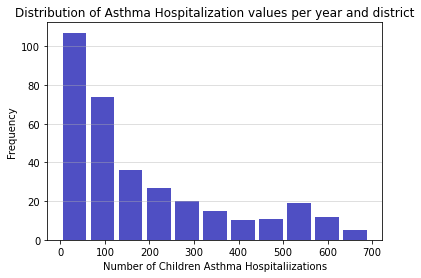

In [43]:
plot_distribution(df.asthma_hosp); plt.xlabel('Number of Children Asthma Hospitaliizations')
plt.title('Distribution of Asthma Hospitalization values per year and district');plt.show()

Number of Children Asthma Hospitalizations has clearly a positive skewed distribution.

- Distribution of Pollutant values per year and district

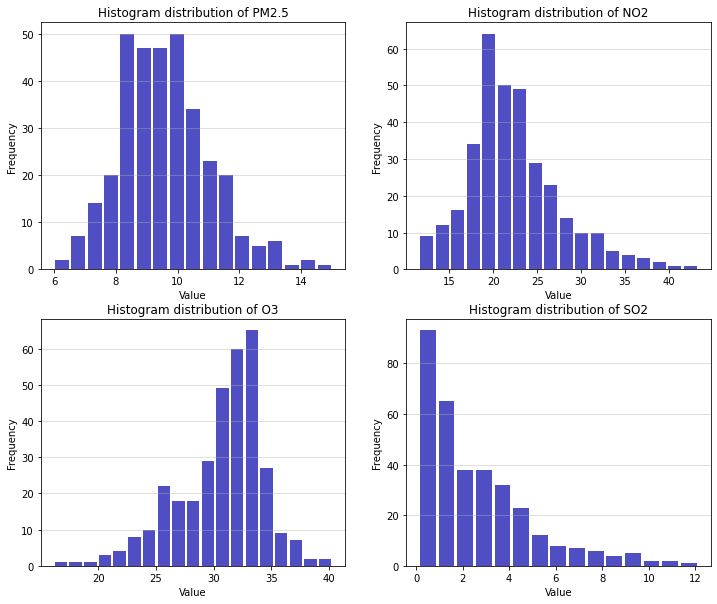

In [44]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1);plot_distribution(df.PM2_5); plt.title('Histogram distribution of PM2.5')
plt.subplot(2,2,2);plot_distribution(df.NO2); plt.title('Histogram distribution of NO2')
plt.subplot(2,2,3);plot_distribution(df.O3); plt.title('Histogram distribution of O3')
plt.subplot(2,2,4);plot_distribution(df.SO2); plt.title('Histogram distribution of SO2');plt.show()

PM2.5 has more a symmetrical distribution while NO2, and SO2 Positive Skewed and O3 negative skewed. In terms of histogram distribution, the number of asthma hospitalizations is most similar to the distribution of SO2 values. Let's take a look now at how the number of asthma cases in children and the levels of pollutants has evolved in the last years, and which tendence do they show.

- Evolution by time of asthma cases and air pollutant values

In [45]:
data=df.copy()
# let's extract the mean astham hosp. values per year
asthma_per_year=[data[data.year==el].asthma_hosp.mean() for el in np.unique(data.year)]

# Mean pollutants per year
PM2_5_per_year=[data[data.year==el].PM2_5.mean() for el in np.unique(data.year)]
NO2_per_year=[data[data.year==el].NO2.mean() for el in np.unique(data.year)]
O3_per_year=[data[data.year==el].O3.mean() for el in np.unique(data.year)]
SO2_per_year=[data[data.year==el].SO2.mean() for el in np.unique(data.year)]

# Extract the years
years=np.unique(data.year)

In [46]:
# Make the plot interactive with plotly go.Scatter
fig = make_subplots(rows=1, cols=5,column_widths=[0.4, 0.15,0.15,0.15,0.15],
    subplot_titles=("Asthma hosp","PM2.5", "NO2", "O3", "SO2"))

fig.add_trace(go.Scatter(x=years, y=asthma_per_year,name='Asthma hosp'),row=1, col=1)

fig.add_trace(go.Scatter(x=years, y=PM2_5_per_year,name='PM2.5'),row=1, col=2)

fig.add_trace(go.Scatter(x=years, y=NO2_per_year,name='NO2'),row=1, col=3)

fig.add_trace(go.Scatter(x=years, y=O3_per_year,name='O3'),row=1, col=4)

fig.add_trace(go.Scatter(x=years, y=SO2_per_year,name='SO2'),row=1, col=5)

# Update xaxis properties
fig.update_xaxes(title_text="year", row=1, col=1);fig.update_xaxes(title_text="year", row=1, col=2)
fig.update_xaxes(title_text="year", row=1, col=3);fig.update_xaxes(title_text="year", row=1, col=4)
fig.update_xaxes(title_text="year", row=1, col=5)

fig.update_layout(height=350, width=1000,
                  title_text='Evolution of Air Pollution and Children Asthma Hospitalizations in NYC')

fig.update_layout(showlegend=False); fig.show()

It can be clearly seen how there is a tendence in decrease in both the number of asthma hospitalizations and the levels of emission of the main pollutants. With the exception of O3, the levels of PM2.5, NO2 and SO2 have been significanlty reduced in the last decade, which evidence that sustainability policies were put into practice. Air quality levels registred during the 2000-2010 decade and their impact on population's health raised the attention of key decision makers and the public which lead to polices aming to improve local air quality, reduce greenhouse gas emissions and revert the situation that air pollution was taking. [[4]](https://www.healthypeople.gov/2020/healthy-people-in-action/story/new-york-city-air-quality-programs-reduce-harmful-air-pollutants)

Once seen how the tendency that both asthma cases and air pollutants are following, the next question that arise is: Is it possible to build a model that relates the number of asthma hospitalizations with the different levels of air pollutants? Which is the impact that each district has?

In [48]:
corr1=np.corrcoef(data.PM2_5,data.asthma_hosp)[0][1]; corr2=np.corrcoef(data.NO2,data.asthma_hosp)[0][1]
corr3=np.corrcoef(data.O3,data.asthma_hosp)[0][1]; corr4=np.corrcoef(data.SO2,data.asthma_hosp)[0][1]

corr_df=pd.DataFrame({'Pollutants':['PM2.5','NO2','O3','SO2'],'Correlation Coef.':[corr1,corr2,corr3,corr4]})

fig = px.bar(corr_df,y='Pollutants',x='Correlation Coef.')
fig.show()

#### Asthma Hospitalizations vs SO2

In [49]:
fig = px.scatter(data, x='SO2', y="asthma_hosp", trendline="ols",color="year")
fig.show()

### 3. Data Analysis.
*Describe your data analysis and explain what you've learned about the dataset. *If relevant, talk about your machine-learning.

#### Machine Learning model implemented

#### Study of pollution per Borough. The case of PM2.5

In [50]:
fig = px.scatter(data, x="PM2_5", y="asthma_hosp", color="year",trendline="ols", facet_col="Boroughs")
fig.show()

### More money = Better healthcare. When the trendline highly varies depending on the district we are located.
Something really interesting can be observed here, and is the fact that really different regression trendlines can be observed depending on the neighbourhood. While in the Bronx the number of asthma hospitalizations strongly increases as the levels of PM2.5 increase, in Manhattan happens exactly the opposite.

Bronx, Brookykn and Queens district seem to show the expected behaviour. As levels of PM2.5 increase, air becomes more polluted, and so the number of asthma hospitalizations increases. However, why does the number of hospitalizations decrease in Manhattan as the levels of air pollution increase?

Different hypothesis appear here. Is it because in the more polluted areas of Manhattan, there is less space for hospitals in which you can treat asthma cases? Or is it because healtcare and quality of life is basically better in Mantattan?

Is it hard to believe that the first hypothesis might be the cause, specially becuase if we look at the more polluted ares of Manhattan we can find hospitals such as the Metropolitan [[5]](https://www.nychealthandhospitals.org/metropolitan/about-us/), which have a Children’s Asthma Program or Bellevue [[6]](https://www.nychealthandhospitals.org/bellevue/health-care-services/childrens-health/) which provides multidisciplinary care for children and adolescents with asthma.

Thus, it seems that these differences are due to the fact that the quality of life and the healthcare services might be better in Manhattan. If we go to check the Median Household Income on 2017 in NYC, we observe that the Bronx has the lowest value with a Median Household Income of 37.397 \\$ , while Manhattan has a value up to 85.071 \\$.



### 4. Genre.
Which genre of data story did you use?
Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

Magazine Style. In terms of Visual Narrative, we have Consistent Visual Platform, Feature Distinction and Zooming?
In terms of Narrative Structure, Linear Ordering, Messaging transmited with Headline, Annotations, Accompanying Articles, and both

### 5. Visualizations.
Explain the visualizations you've chosen.
Why are they right for the story you want to tell?

### 6. Discussion. Think critically about your creation
What went well?
What is still missing? What could be improved? Why?

#### Contributions. Who did what?

*You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).

It is not OK simply to write "All group members contributed equally".

#### Make sure that you use references when they're needed and follow academic standards.
Handing in the assignment: Simply upload the link to your website to peergrade.